In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Imports
import numpy as np
import pandas as pd
import plotly as ply
import plotly.express as px
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from collections import defaultdict
from tqdm import tqdm

def def_value():
  return 0

class DBScan():
  def __init__(self, df, eps=0.1, minpts=3):
    self.eps = eps
    self.minpts = minpts
    self.df = df

  def identify_types(self):
    types = ['']*len(self.df)

    for i in range(len(self.df)):
      row = self.df.loc[self.df['pt']==i]
      neighbors = row['num_neighbors'].values[0]

      if neighbors>=self.minpts:
        types[i] = 'core'

    self.df['type'] = types
    df_non_core = self.df.loc[self.df['type']!='core']

    for e in df_non_core.iterrows():
      e = e[1]
      neighbors = np.array(e['neighbors'].split(',')).astype('int')
      for n in neighbors:
        p = self.df.loc[self.df['pt']==n, 'pt'].values[0]
        if types[p]=='core':
          types[e['pt']]='border'
          break

    types = ['noise' if e=='' else e for e in types]
    self.df['type'] = types


  def run(self):
    visited = [0]*len(self.df)
    cl = 1

    neighbors = self.df['neighbors']
    types = self.df['type']
    clusters = [-1]*len(self.df)

    for i in range(len(self.df)):
      if not visited[i]:
        queue = []
        if types[i]=='core':
          queue.append(i)

        visited[i] = 1
        clusters[i]=cl
        while len(queue)>0:
          s = queue.pop(0)
          for y in np.array(neighbors[s].split(',')).astype('int'):
            if not visited[y]:
              visited[y] = 1
              if types[y]=='core':
                queue.append(y)
                clusters[y]=cl
              else:
                clusters[y] = cl
        cl+=1

    self.df['cls'] = clusters
    self.df.loc[self.df['type']=='border','cls'] = 0
    self.df.loc[self.df['type']=='noise','cls'] = -1

def get_neighbors(data, eps, min_samples):
  neighbors = []
  num_neighbors = []

  # Iterate over the data points.
  for i in tqdm(range(len(data))):

    # Check if the current data point is a core point.
    n = np.where(np.linalg.norm(data[i] - data, axis=1) < eps)[0]
    neighbors.append(",".join([str(e) for e in n]))
    num_neighbors.append(len(n))

  return neighbors, num_neighbors

In [ ]:
import numpy as np

def calculate_purity(true_labels, predicted_labels):
    # Create a contingency matrix
    contingency_matrix = np.zeros((len(true_labels), len(predicted_labels)))
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        contingency_matrix[true_label][predicted_label] += 1

    # Calculate purity
    purity = np.max(np.sum(contingency_matrix, axis=0) / len(true_labels))
    return purity

def calculate_gini_index(true_labels, predicted_labels):
    # Create a contingency matrix
    contingency_matrix = np.zeros((len(true_labels), len(predicted_labels)))
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        contingency_matrix[true_label][predicted_label] += 1

    # Calculate Gini index
    class_counts = np.sum(contingency_matrix, axis=1)
    total_samples = np.sum(class_counts)
    probabilities = class_counts / total_samples
    gini_index = 1 - np.sum(probabilities ** 2)
    return gini_index

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/UML_HW_Datasets/dbscan.csv')
df.head()

,cluster,pt,x,y,num_neighbors,neighbors
0,NaN,0,51.418089,13.593610,2,"0,27"
1,NaN,1,39.132318,-4.419204,3,"1,40,75"
2,NaN,2,47.807515,-25.822561,1,2
3,NaN,3,27.699703,53.434193,1,3
4,NaN,4,39.860995,5.676871,3,"4,56,75"


<Axes: xlabel='x', ylabel='y'>

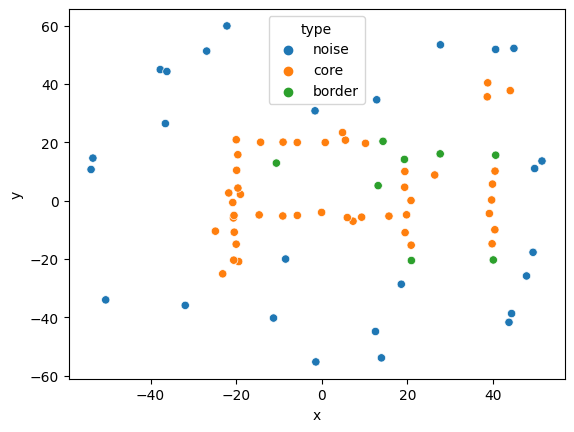

In [ ]:
# Plotting noise border and core points.
sns.scatterplot(data=df, x='x', y='y', hue='type')

In [ ]:
dbscan = DBScan(df.copy(),eps=7.5, minpts=3)
dbscan.identify_types()
dbscan.run()

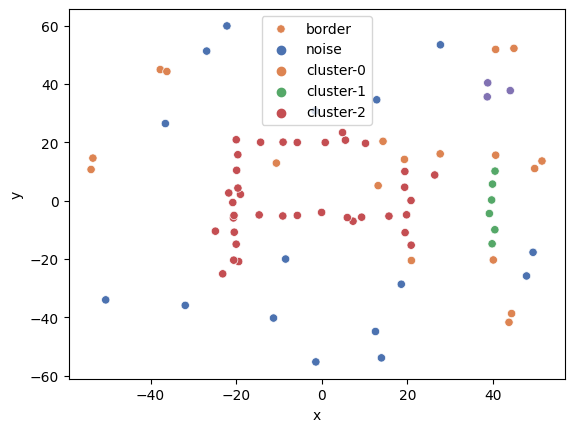

In [ ]:
sns.scatterplot(data=dbscan.df,x='x', y='y', hue='cls', palette='deep')
plt.legend(['border', 'noise', *[f'cluster-{e}' for e in range(len(np.unique(dbscan.df['cls'])[2:]))]], loc='best')
plt.show()

## Problem-6

In [ ]:
from sklearn.datasets import make_circles, make_blobs, make_moons

In [ ]:
data_circles, labels = make_circles(n_samples=100)

In [ ]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs, make_moons
import matplotlib.pyplot as plt


# Generate the three toy 2D datasets.
circles, labels = make_circles(n_samples=100)
circles_neighbors, circles_num_neighbors = get_neighbors(circles, eps=0.3, min_samples=10)

df_circle = pd.DataFrame()
df_circle['x'] = circles[:, 0]
df_circle['y'] = circles[:, 1]
df_circle['neighbors'] = circles_neighbors
df_circle['num_neighbors'] = circles_num_neighbors
df_circle['type'] = ['']*len(df_circle)
df_circle['label'] = labels

100%|██████████| 100/100 [00:00<00:00, 16953.53it/s]


In [ ]:
df_circle = df_circle.reset_index().rename(columns={'index':'pt'})

<Axes: xlabel='x', ylabel='y'>

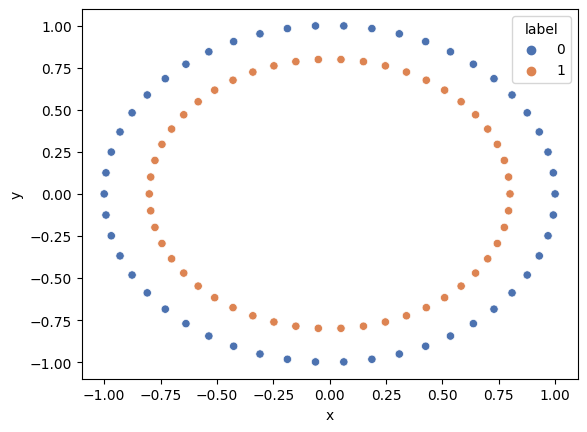

In [ ]:
dbscan = DBScan(df_circle.copy(),eps=0.1, minpts=10)
dbscan.identify_types()
dbscan.run()
sns.scatterplot(data=dbscan.df,x='x', y='y', hue='label', palette='deep')

In [ ]:
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x=dbscan.df['x'].values,
                         y=dbscan.df['y'].values,
                         mode='markers+text',
                         marker=dict(color=dbscan.df['label'].values)),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dbscan.df['x'].values,
                         y=dbscan.df['y'].values,
                         mode='markers+text',
                         marker=dict(color=dbscan.df['label'].values)),
              row=1, col=2)

fig.update_layout(height=600, width=800, title_text="Comparison between true and estimated clusters", coloraxis=dict(colorscale='darkmint'))
fig.show()

In [ ]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs, make_moons
import matplotlib.pyplot as plt

def get_neighbors(data, eps, min_samples):
  neighbors = []
  num_neighbors = []

  # Iterate over the data points.
  for i in range(len(data)):

    # Check if the current data point is a core point.
    n = np.where(np.linalg.norm(data[i] - data, axis=1) < eps)[0]
    neighbors.append(",".join([str(e) for e in n]))
    num_neighbors.append(len(n))

  return neighbors, num_neighbors


# Generate the three toy 2D datasets.
blobs, labels = make_blobs(n_samples=100)
blobs_neighbors, blobs_num_neighbors = get_neighbors(blobs, eps=0.3, min_samples=10)


df_blobs = pd.DataFrame()
df_blobs['x'] = blobs[:, 0]
df_blobs['y'] = blobs[:, 1]
df_blobs['neighbors'] = blobs_neighbors
df_blobs['num_neighbors'] = blobs_num_neighbors
df_blobs['type'] = ['']*len(df_blobs)
df_blobs['label'] = labels

In [ ]:
df_blobs = df_blobs.reset_index().rename(columns={'index':'pt'})

<Axes: xlabel='x', ylabel='y'>

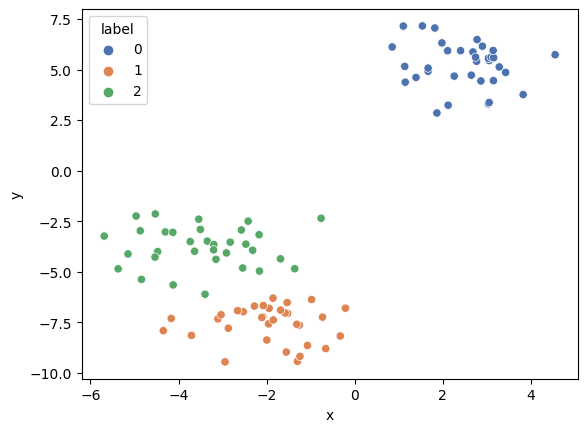

In [ ]:
dbscan = DBScan(df_blobs.copy(),eps=1, minpts=3)
dbscan.identify_types()
dbscan.run()
sns.scatterplot(data=dbscan.df,x='x', y='y', hue='label', palette='deep')

In [ ]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x=dbscan.df['x'].values,
                         y=dbscan.df['y'].values,
                         mode='markers+text',
                         marker=dict(color=dbscan.df['label'].values)),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dbscan.df['x'].values,
                         y=dbscan.df['y'].values,
                         mode='markers+text',
                         marker=dict(color=dbscan.df['cls'].values)),
              row=1, col=2)

fig.update_layout(height=600, width=800, title_text="Comparison between true and estimated clusters", coloraxis=dict(colorscale='darkmint'))
fig.show()

In [ ]:
# Generate the three toy 2D datasets.
moons, labels = make_moons(n_samples=100)
moons_neighbors, moons_num_neighbors = get_neighbors(moons, eps=0.3, min_samples=10)


df_moons = pd.DataFrame()
df_moons['x'] = moons[:, 0]
df_moons['y'] = moons[:, 1]
df_moons['neighbors'] = moons_neighbors
df_moons['num_neighbors'] = moons_num_neighbors
df_moons['type'] = ['']*len(df_moons)
df_moons['label'] = labels

<Axes: xlabel='x', ylabel='y'>

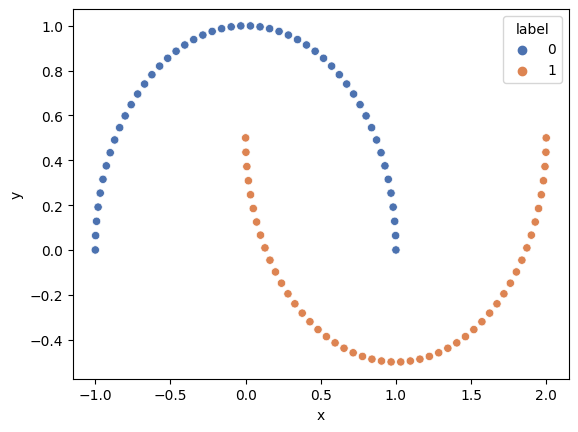

In [ ]:
df_moons = df_moons.reset_index().rename(columns={'index':'pt'})

dbscan = DBScan(df_moons.copy(),eps=1, minpts=3)
dbscan.identify_types()
dbscan.run()
sns.scatterplot(data=dbscan.df,x='x', y='y', hue='label', palette='deep')

In [ ]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x=dbscan.df['x'].values,
                         y=dbscan.df['y'].values,
                         mode='markers+text',
                         marker=dict(color=dbscan.df['label'].values)),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dbscan.df['x'].values,
                         y=dbscan.df['y'].values,
                         mode='markers+text',
                         marker=dict(color=dbscan.df['label'].values)),
              row=1, col=2)

fig.update_layout(height=600, width=800, title_text="Comparison between true and estimated clusters", coloraxis=dict(colorscale='darkmint'))
fig.show()

# Problem-7

In [ ]:
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

In [ ]:
train = fetch_20newsgroups(subset="train", random_state=42)
x_train_news, x_test_news, y_train_news, y_test_news = train_test_split(train['data'], train['target'], stratify=train['target'], test_size=0.8, random_state=43)

tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train_news)
x_test_tfidf = tfidf.transform(x_test_news)

In [ ]:
ng_neighbors, ng_num_neighbors = get_neighbors(x_train_tfidf.toarray()[:100], 1.35, 15)

100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


In [ ]:
df_ng = pd.DataFrame()
df_ng['neighbors'] = ng_neighbors
df_ng['num_neighbors'] = ng_num_neighbors
df_ng['type'] = ['']*len(df_ng)
df_ng['label'] = y_train_news[:100]
df_ng['pt'] = [i for i in range(len(df_ng))]

In [ ]:
dbscan = DBScan(df_ng.copy(), 1.35,5)
dbscan.identify_types()
dbscan.run()

In [ ]:
dbscan.df

,neighbors,num_neighbors,type,label,pt,cls
0,"0,1,3,8,9,11,12,16,18,21,25,27,28,29,31,33,35,...",43,core,16,0,1
1,"0,1,9,11,12,16,25,27,28,29,35,38,43,51,58,60,6...",22,core,0,1,1
2,"2,9,11,21,25,35,38,43,58,68,81,91",12,core,2,2,1
3,"0,3,8,9,11,12,21,25,27,28,29,31,33,35,36,38,42...",28,core,13,3,1
4,"4,38,58",3,border,13,4,0
...,...,...,...,...,...,...
95,"0,1,3,8,9,11,12,16,18,21,25,27,28,29,31,33,35,...",40,core,16,95,1
96,"43,96",2,border,12,96,0
97,"0,9,11,12,13,16,25,27,28,29,35,38,42,43,51,58,...",24,core,10,97,1
98,"58,98",2,border,3,98,0


In [ ]:
print('Purity: ',calculate_purity(dbscan.df['label'], dbscan.df['cls']))
print('Gini Coefficient: ', round(calculate_gini_index(dbscan.df['label'], dbscan.df['cls']),2))

Purity:  0.57
Gini Coefficient:  0.94


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
fmnist_path = '/content/gdrive/MyDrive/UML_HW_Datasets/FMNIST/fashion-mnist_train.csv'

fmnist_df = pd.read_csv(fmnist_path)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(fmnist_df.drop('label', axis=1), fmnist_df['label'], test_size=0.8, random_state=42)

x_train = x_train[:5000]

std = MinMaxScaler()
x_train_std = std.fit_transform(x_train)

fmnist_neighbors, fmnist_num_neighbors = get_neighbors(x_train_std, 10, 5)

100%|██████████| 5000/5000 [01:44<00:00, 47.70it/s]


In [ ]:
df_fmnist = pd.DataFrame()
df_fmnist['neighbors'] = fmnist_neighbors
df_fmnist['num_neighbors'] = fmnist_num_neighbors
df_fmnist['type'] = ['']*len(df_fmnist)
df_fmnist['label'] = y_train[:5000].values
df_fmnist['pt'] = [i for i in range(len(df_fmnist))]

In [ ]:
dbscan = DBScan(df_fmnist.copy(), 10,5)
dbscan.identify_types()
dbscan.run()

In [ ]:
dbscan.df

,neighbors,num_neighbors,type,label,pt,cls
0,"0,2,8,10,14,18,21,24,28,30,31,32,33,36,37,41,4...",1686,core,5,0,1
1,"1,3,4,6,12,13,40,43,47,55,62,64,66,70,79,80,84...",927,core,2,1,1
2,"0,2,5,10,14,18,28,31,33,36,41,46,48,52,54,56,5...",1238,core,7,2,1
3,"1,3,4,6,7,9,12,13,30,35,39,40,43,47,51,55,60,6...",1997,core,6,3,1
4,"1,3,4,6,9,12,13,35,39,40,43,47,51,55,62,64,66,...",1437,core,6,4,1
...,...,...,...,...,...,...
4995,"8,10,11,14,15,19,21,22,28,30,35,36,39,44,45,46...",1464,core,1,4995,1
4996,"3,4,6,9,13,20,39,40,51,55,60,62,64,66,70,73,78...",829,core,2,4996,1
4997,"3,4,7,9,12,16,19,22,27,35,39,40,51,55,60,61,64...",1314,core,0,4997,1
4998,"9,11,12,22,39,45,51,53,59,60,61,67,73,75,78,82...",1219,core,3,4998,1


In [ ]:
print('Purity: ',calculate_purity(dbscan.df['label'], dbscan.df['cls']))
print('Gini Coefficient: ', round(calculate_gini_index(dbscan.df['label'], dbscan.df['cls']),2))

Purity:  0.9996
Gini Coefficient:  0.9


In [ ]:
household_path = '/content/gdrive/MyDrive/UML_HW_Datasets/household_power_consumption.txt'

df = pd.read_csv(household_path, sep=';')

<ipython-input-22-c2f160d0a0db>:3: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(household_path, sep=';')


## Evaluate using the Silhouttee score.

It should be 0.6


In [ ]:
data = df.drop(['Date', 'Time'], axis=1)
data = data.dropna()
for col in data.columns:
  data[col] = data[col].astype('float')

data = data.values

In [ ]:
data = data[:10000]

In [ ]:
h_neighbors, h_num_neighbors = get_neighbors(data, 1.35, 10)

100%|██████████| 10000/10000 [00:07<00:00, 1282.79it/s]


In [ ]:
df_h = pd.DataFrame()
df_h['neighbors'] = h_neighbors
df_h['num_neighbors'] = h_num_neighbors
df_h['type'] = ['']*len(df_h)
df_h['pt'] = [i for i in range(len(df_h))]

In [ ]:
dbscan = DBScan(df_h.copy(), 1.35,10)
dbscan.identify_types()
dbscan.run()

In [ ]:
dbscan.df

,neighbors,num_neighbors,type,pt,cls
0,"0,53,81",3,core,0,1
1,"1,12",2,noise,1,-1
2,"2,13",2,noise,2,-1
3,3,1,noise,3,-1
4,"4,6,7,1428,1432,1436,1627,1628,1629,1631,4346,...",12,core,4,5
...,...,...,...,...,...
9995,"9994,9995,9996",3,core,9995,13
9996,"9994,9995,9996",3,core,9996,13
9997,"9910,9913,9997",3,core,9997,12
9998,"2588,2843,2844,9569,9845,9914,9915,9923,9998,9999",10,core,9998,13


In [ ]:
round(silhouette_score(data,dbscan.df['cls']),1)

0.6

## Problem-8

In [ ]:
import numpy as np
from sklearn.datasets import make_moons
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial import distance_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Generate the moons dataset
X, _ = make_moons(n_samples=5000, noise=0.05, random_state=42)

In [ ]:
import numpy as np
from scipy.spatial import distance_matrix
def single_linkage_matrix(X):
    n_samples = X.shape[0]

    distances = np.sqrt(np.sum((X[:, np.newaxis] - X) ** 2, axis=-1))
    np.fill_diagonal(distances, np.inf)

    linkage_matrix = []
    cluster_indices = [np.array([i]) for i in range(n_samples)]

    while len(cluster_indices) > 1:
        i, j = np.unravel_index(np.argmin(distances), distances.shape)
        merge_indices = (i, j)

        merged_cluster = np.union1d(cluster_indices[i], cluster_indices[j])
        linkage_matrix.append([cluster_indices[i][0], cluster_indices[j][0], distances[i, j], len(merged_cluster)])

        # Update distances

        distances = np.delete(distances, j, axis=0)
        distances = np.delete(distances, j, axis=1)

        distances[i] = np.minimum(distances[i], distances[j-1])

        distances[:, i] = distances[i]
        cluster_indices[i] = merged_cluster

        cluster_indices = np.delete(cluster_indices, j)

    return np.array(linkage_matrix)

In [ ]:
single_linkage = single_linkage_matrix(X)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


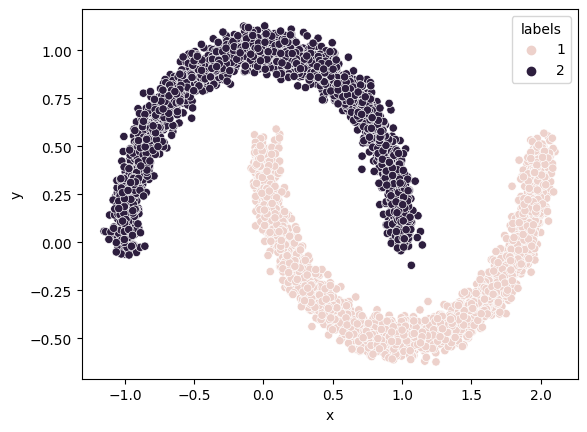

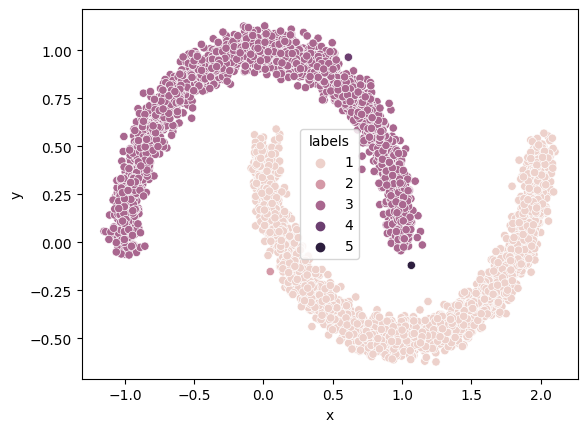

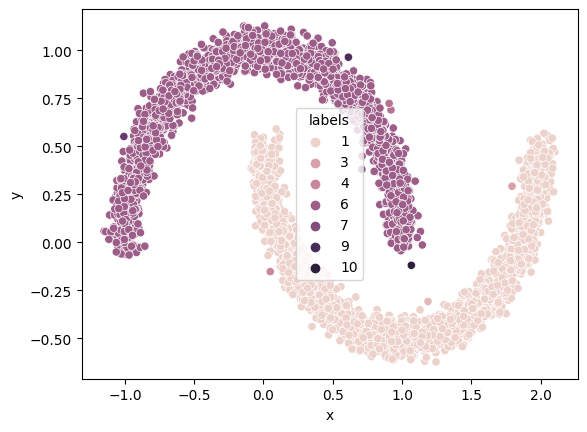

In [ ]:
k_values = [2, 5, 10]

for k in k_values:
    single_labels = fcluster(single_linkage, k, criterion='maxclust')

    df = pd.DataFrame()
    df['labels'] = single_labels
    df['x'] = X[:,0]
    df['y'] = X[:, 1]


    sns.scatterplot(data=df, x='x', y='y', hue='labels')
    plt.show()